In [1]:
import math
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, namedtuple
import os
import subprocess
from tqdm import trange
from copy import deepcopy

from env import Scenario, AMoD
from util import mat2str, dictsum, moving_average

# DQN imports 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

plt.style.use('ggplot')
CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.lin_input_to_hidden = nn.Linear(input_dim, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.lin_hidden_to_hidden = nn.Linear(32, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.head = nn.Linear(32, output_dim)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.bn1(self.lin_input_to_hidden(x)))
        x = self.relu(self.bn2(self.lin_hidden_to_hidden(x)))
        return self.head(x.view(x.size(0), -1))

In [ ]:
def select_action(state, policy_net, test=False):
    global steps_done
    sample = random.random()
    if test:
        eps_threshold = 0.
    else:
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(cdqn.nA)]], device=device, dtype=torch.long)

def optimize_model(policy_net, target_net, memory, optimizer):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state).float()
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    policy_net.train()
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [4]:
from collections import defaultdict
import numpy as np
import subprocess
import os
import networkx as nx
from util import mat2str
from copy import deepcopy

DQN_set = namedtuple('DQN_set',
                    ('policy_net', 'target_net', 'replay_buffer', 'optimizer'))

class CascadedDQN():
    # initialization
    def __init__(self, env):
        # book-keeping variables
        self.L = 3 # number of levels
        self.Ms = 5 # state-space discretization
        self.Ma = 5 # action-space discretization
        self.K = 1 # number of time-intervals
        self.nA = self.Ma # number of actions
        self.nS = self.K * (self.Ms + 1) # number of states (+1 represents extra state'lambda')
        self.env = env # simulated environment
        self.region = env.region # list of cells
        self.n_vehicles = env.G.nodes[0]['accInit']*len(env.region) # total number of vehicles
        self.cascaded_regions = self._get_cascaded_regions() # regions for each level of cascade, key: l - 'level', r: - 'region'
        
        # initialize state/action spaces
        # state_space: list with elements (k, vleft, vright) -> observed distribution of AVs (at time k)
        # action_space: list with elements (vleft, vright) -> desired distribution of AVs 
        self.state_space, self.action_space = self._get_state_action_space()
        self.dqn_set = self._get_q_networks() # initialize Q-networks/Target Network/Replay Buffers/Optimizers, key: l - 'level', n: - 'node'
        self.nodes = list(self.dqn_set.keys())
    
    def _get_cascaded_regions(self):
        cascaded_regions = dict()
        for l in range(1, self.L+1):
            n_l = 2**(l) # number of nodes in level 'l'
            splits = np.array_split(self.region, n_l)
            for node, split in enumerate(splits):
                cascaded_regions[l-1, node+1] = split
        return cascaded_regions
    
    def _get_state_action_space(self):
        vs_state = np.linspace(0, 1, self.Ms) # enumerate all possible v_i values 
        vs_action = np.linspace(0, 1, self.Ma) # enumerate all possible x_i^d values
        state_space, action_space = [], []
        for vleft in vs_state:
            for k in range(self.K):
                state_space.append((k, vleft, 1-vleft))
            action_space.append((vleft, 1-vleft))
        state_space.append((0, 0., 0.))
        return state_space, action_space
    
    def _get_q_networks(self, device=torch.device("cpu")):
        """
        Returns dictionary pointing towards DQN modules (Q, target net, replay buffer, optimizer)
        for every node in cascade.
        """
        dqn_set = dict()
        for l in range(1, self.L+1):
            n_l = 2**(l-1) # number of nodes in level 'l'
            for n in range(n_l):
                policy_net_l_n = DQN(input_dim=3, output_dim=self.nA).to(device)
                target_net_l_n = DQN(input_dim=3, output_dim=self.nA).to(device)
                target_net_l_n.load_state_dict(policy_net_l_n.state_dict())
                target_net_l_n.eval()
                replay_buffer_l_n = ReplayMemory(10000)
                optimizer_l_n = optim.RMSprop(policy_net_l_n.parameters())
                dqn_set[l-1, n+1] =  DQN_set(policy_net_l_n, target_net_l_n, 
                                             replay_buffer_l_n, optimizer_l_n)
        return dqn_set
    
    def decode_state(self, raw_s, t):
        """
        Decodes raw environment state into state representation for learning.
        
        Parameters
        ----------
        raw_s : array_like
                Availability of idle vehicles as in env.acc.
        t : int
            Current environemt time.
        Returns
        -------
        s : array_like
            Idle vehicle distribution for every node.
        """
        k = t%self.K
        s = []
        list_regions = list(self.cascaded_regions.keys())
        for i in range(0, len(list_regions)-1, 2):
            x_left, x_right = 0, 0
            for cell in self.cascaded_regions[list_regions[i]]:
                x_left += raw_s[cell][t]
            for cell in self.cascaded_regions[list_regions[i+1]]:
                x_right += raw_s[cell][t]
            if x_left==x_right==0.:
#                 print(f"lambda, xl {x_left}, xr {x_right}")
                s.append((0, 0., 0.))
            else:
                v_left = min(np.linspace(0, 1, self.Ms), key=lambda x:abs(x - (x_left / (x_left + x_right))))
                v_right = 1 - v_left
                s.append((k, v_left, v_right))
        return s
    
    def encode_state(self, s):
        """
        Encodes state representation into index for state-space list.
        
        Parameters
        ----------
        s : list
            State representation.
        Returns
        -------
        idx : int
            Index value for s in state_space
        """
        idx = self.state_space.index(s)
        return idx
    
    def get_desired_distribution(self, action_rl):
        """
        Given a RL action, returns the desired number of vehicles in each area.
        """
        v_d = [[] for _ in range(2**self.L)]
        for i, region in enumerate(list(self.cascaded_regions.keys())):
            for cell in self.cascaded_regions[region]:
                v_d[cell].append(self.action_space[action_rl[i//2]][i%2])
        return np.prod(v_d, axis=1)*self.get_available_vehicles()
    
    def get_available_vehicles(self):
        """
        Count total number of available vehicles.
        """
        return np.sum([self.env.acc[region][self.env.time] for region in self.env.region])

In [5]:
scenario = Scenario(demand_input = {(1,6):2, (0,7):2, 'default':0.1})

In [6]:
env = AMoD(scenario)

In [7]:
cdqn = CascadedDQN(env)

In [8]:
cdqn.dqn_set[(2,4)].policy_net

DQN(
  (lin_input_to_hidden): Linear(in_features=3, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin_hidden_to_hidden): Linear(in_features=32, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Linear(in_features=32, out_features=5, bias=True)
  (relu): ReLU()
)

In [9]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.95
EPS_END = 0.01
EPS_DECAY = 60*10
TARGET_UPDATE = 10

In [15]:
params = {"training_round_len" : 600, # number of steps for which to train the same the same node (here 10 episodes of length 60) 
          "epsilon" : 1, # epsilon greedy initial parameter
          "k" : 0, # counter for Q table indexing (top-down learning)
          "default_action" : cdqn.action_space.index((0.5, 0.5))} # default behavior is to distribute vehicles equally
num_nodes = len(cdqn.nodes)

# book-keeping variables
training_rewards = []
training_revenue = []
training_served_demand = []
training_rebalancing_cost = []
training_operating_cost = []

# last_t_update = 0
train_episodes = 10*500 # num_of_episodes_with_same_epsilon x num_of_q_tables x num_epsilons          
max_steps = 100 # maximum length of episode
epochs = trange(train_episodes) # build tqdm iterator for loop visualization
steps_done = 0

idx = (params["k"]//params["training_round_len"])%num_nodes # Q table index (initially, top-most node)
node = cdqn.nodes[idx] # select top-most node (i.e. (0, 1))
switching_iters = np.linspace(0, (num_nodes-1)*params["training_round_len"], num_nodes) 

for i_episode in epochs:
    try:
        obs = env.reset()
        state = torch.tensor(cdqn.decode_state(obs[0], obs[1])[0]).to(device).view(-1, 3)
        episode_reward = 0
        episode_revenue = 0
        episode_served_demand = 0
        episode_rebalancing_cost = 0
        episode_operating_cost = 0
        for step in range(max_steps):
            # Select and perform an RL action
            idx = (params["k"]//params["training_round_len"])%num_nodes # Q table index (initially, top-most node)
            node = cdqn.nodes[idx] # select node (i.e. (0, 1))
            policy_net = cdqn.dqn_set[node].policy_net
            target_net = cdqn.dqn_set[node].target_net
            memory = cdqn.dqn_set[node].replay_buffer
            optimizer = cdqn.dqn_set[node].optimizer
            action_rl = []
            for i in range(num_nodes):
                state_i = torch.tensor(cdqn.decode_state(obs[0], obs[1])[i]).to(device).view(-1, 3)
                node_i = cdqn.nodes[i]
                policy_net_i = cdqn.dqn_set[node_i].policy_net
                if i==idx:
                    policy_net.eval()
                    action_rl.append(select_action(state_i, policy_net).item())
                else: # for all other nodes, select either default action or take argmax Q(:,a) 
                    policy_net_i.eval()
                    if (params["k"]//(params["training_round_len"]*num_nodes) < 1) and (params["k"]//100 < i):
                        action_rl.append(params["default_action"])
                    else:
                        action_rl.append(select_action(state_i, policy_net_i).item())

            # 1.2 get actual vehicle distributions vi (i.e. (x1*x2*..*xn)*num_vehicles)
            v_d = cdqn.get_desired_distribution(action_rl)

            # 1.3 Solve ILP - Minimal Distance Problem 
            # 1.3.1 collect inputs and build .dat file
            t = cdqn.env.time
            accTuple = [(n,int(cdqn.env.acc[n][t])) for n in cdqn.env.acc]
            accRLTuple = [(n, int(v_d_n)) for n, v_d_n in enumerate(v_d)]
            edgeAttr = [(i,j,cdqn.env.G.edges[i,j]['time']) for i,j in cdqn.env.G.edges]
            modPath = os.getcwd().replace('\\','/')+'/mod/'
            OPTPath = os.getcwd().replace('\\','/')+'/OPT/CDQN/v2/'
            if not os.path.exists(OPTPath):
                os.makedirs(OPTPath)
            datafile = OPTPath + f'data_{t}.dat'
            resfile = OPTPath + f'res_{t}.dat'
            with open(datafile,'w') as file:
                file.write('path="'+resfile+'";\r\n')
                file.write('edgeAttr='+mat2str(edgeAttr)+';\r\n')
                file.write('accInitTuple='+mat2str(accTuple)+';\r\n')
                file.write('accRLTuple='+mat2str(accRLTuple)+';\r\n')

            # 2. execute .mod file and write result on file
            modfile = modPath+'minRebDistRebOnly.mod'
            if CPLEXPATH is None:
                CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
            my_env = os.environ.copy()
            my_env["LD_LIBRARY_PATH"] = CPLEXPATH
            out_file =  OPTPath + f'out_{t}.dat'
            with open(out_file,'w') as output_f:
                subprocess.check_call([CPLEXPATH+"oplrun", modfile, datafile], stdout=output_f, env=my_env)
            output_f.close()

            # 3. collect results from file
            flow = defaultdict(float)
            with open(resfile,'r', encoding="utf8") as file:
                for row in file:
                    item = row.strip().strip(';').split('=')
                    if item[0] == 'flow':
                        values = item[1].strip(')]').strip('[(').split(')(')
                        for v in values:
                            if len(v) == 0:
                                continue
                            i,j,f = v.split(',')
                            flow[int(i),int(j)] = float(f)
            rebAction = [flow[i,j] for i,j in cdqn.env.edges]

            # Take step
            new_obs, reward, done, info = env.step(rebAction, isMatching=True, CPLEXPATH=CPLEXPATH, PATH="CDQN/v2/")
            new_state = torch.tensor([cdqn.decode_state(new_obs[0], new_obs[1])[idx]]).to(device)

            reward = torch.tensor([reward], device=device).float()

            # Store the transition in memory
            memory.push(state, torch.tensor([[action_rl[idx]]]), new_state, reward)

            # Move to the next state
            # track performance over episode
            episode_reward += reward.item()
            episode_revenue += info['revenue']
            episode_served_demand += info['served_demand']
            episode_rebalancing_cost += info['rebalancing_cost']
            episode_operating_cost += info['operating_cost']
            obs, state = deepcopy(new_obs), deepcopy(new_state)
            params["k"] += 1
            
            # Perform one step of the optimization (on the target network)
            optimize_model(policy_net, target_net, memory, optimizer)
            if done:
                break
        # Update the target network, copying all weights and biases in DQN
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
            last_t_update = i_episode
        epochs.set_description(f"Episode {i_episode+1} | Reward: {episode_reward:.2f} | Revenue: {episode_revenue:.2f} | ServedDemand: {episode_served_demand:.2f} \
| Reb. Cost: {episode_rebalancing_cost:.2f} | Oper. Cost: {episode_operating_cost:.2f}| Epsilon: {EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)},\
Idx: {idx} | Last Target Update {last_t_update}")
        #Adding the total reward and reduced epsilon values
        training_rewards.append(episode_reward)
        training_revenue.append(episode_revenue)
        training_served_demand.append(episode_served_demand)
        training_rebalancing_cost.append(episode_rebalancing_cost)
        training_operating_cost.append(episode_operating_cost)
    except KeyboardInterrupt:
        break

Episode 1857 | Reward: 1631.20 | Revenue: 1902.86 | ServedDemand: 286.00 | Reb. Cost: 111.80 | Oper. Cost: 280.00| Epsilon: 0.01,Idx: 3 | Last Target Update 1850:  37%|███▋      | 1857/5000 [3:00:11<5:41:08,  6.51s/it]        IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Test Episodes 

In [16]:
# Test Episodes
test_episodes = 100
epochs = trange(test_episodes) # build tqdm iterator for loop visualization
np.random.seed(10)

# book-keeping variables
test_rewards = []
test_revenue = []
test_served_demand = []
test_rebalancing_cost = []
test_operating_cost = []

for episode in epochs:
    try:
        obs = env.reset()
        state = torch.tensor(cdqn.decode_state(obs[0], obs[1])[0]).to(device).view(-1, 3)
        episode_reward = 0
        episode_revenue = 0
        episode_served_demand = 0
        episode_rebalancing_cost = 0
        episode_operating_cost = 0
        for step in range(max_steps):
            action_rl = []
            for i in range(num_nodes):
                state_i = torch.tensor(cdqn.decode_state(obs[0], obs[1])[i]).to(device).view(-1, 3)
                node_i = cdqn.nodes[i]
                policy_net_i = cdqn.dqn_set[node_i].policy_net
                policy_net_i.eval()
                action_rl.append(select_action(state_i, policy_net_i, test=True).item())

            # 1.2 get actual vehicle distributions vi (i.e. (x1*x2*..*xn)*num_vehicles)
            v_d = cdqn.get_desired_distribution(action_rl)

            # 1.3 Solve ILP - Minimal Distance Problem 
            # 1.3.1 collect inputs and build .dat file
            t = cdqn.env.time
            accTuple = [(n,int(cdqn.env.acc[n][t])) for n in cdqn.env.acc]
            accRLTuple = [(n, int(v_d_n)) for n, v_d_n in enumerate(v_d)]
            edgeAttr = [(i,j,cdqn.env.G.edges[i,j]['time']) for i,j in cdqn.env.G.edges]
            modPath = os.getcwd().replace('\\','/')+'/mod/'
            OPTPath = os.getcwd().replace('\\','/')+'/OPT/CDQN/Testv1/'
            if not os.path.exists(OPTPath):
                os.makedirs(OPTPath)
            datafile = OPTPath + f'data_{t}.dat'
            resfile = OPTPath + f'res_{t}.dat'
            with open(datafile,'w') as file:
                file.write('path="'+resfile+'";\r\n')
                file.write('edgeAttr='+mat2str(edgeAttr)+';\r\n')
                file.write('accInitTuple='+mat2str(accTuple)+';\r\n')
                file.write('accRLTuple='+mat2str(accRLTuple)+';\r\n')

            # 2. execute .mod file and write result on file
            modfile = modPath+'minRebDistRebOnly.mod'
            if CPLEXPATH is None:
                CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
            my_env = os.environ.copy()
            my_env["LD_LIBRARY_PATH"] = CPLEXPATH
            out_file =  OPTPath + f'out_{t}.dat'
            with open(out_file,'w') as output_f:
                subprocess.check_call([CPLEXPATH+"oplrun", modfile, datafile], stdout=output_f, env=my_env)
            output_f.close()

            # 3. collect results from file
            flow = defaultdict(float)
            with open(resfile,'r', encoding="utf8") as file:
                for row in file:
                    item = row.strip().strip(';').split('=')
                    if item[0] == 'flow':
                        values = item[1].strip(')]').strip('[(').split(')(')
                        for v in values:
                            if len(v) == 0:
                                continue
                            i,j,f = v.split(',')
                            flow[int(i),int(j)] = float(f)
            rebAction = [flow[i,j] for i,j in cdqn.env.edges]
    
            # Take step
            new_obs, reward, done, info = env.step(rebAction, isMatching=True, CPLEXPATH=CPLEXPATH, PATH="CDQN/Testv1/")
            new_state = torch.tensor([cdqn.decode_state(new_obs[0], new_obs[1])[0]]).to(device)
            
            # track performance over episode
            episode_reward += reward
            episode_revenue += info['revenue']
            episode_served_demand += info['served_demand']
            episode_rebalancing_cost += info['rebalancing_cost']
            episode_operating_cost += info['operating_cost']
            obs, state = deepcopy(new_obs), deepcopy(new_state)

            # end episode if conditions reached
            if done:
                break
            
        epochs.set_description(f"Episode {episode+1} | Reward: {episode_reward:.2f} | Revenue: {episode_revenue:.2f} | ServedDemand: {episode_served_demand:.2f} \
| Oper. Cost: {episode_operating_cost:.2f}")
        #Adding the total reward and reduced epsilon values
        test_rewards.append(episode_reward)
        test_revenue.append(episode_revenue)
        test_served_demand.append(episode_served_demand)
        test_rebalancing_cost.append(episode_rebalancing_cost)
        test_operating_cost.append(episode_operating_cost)
    except KeyboardInterrupt:
        break

Episode 100 | Reward: 1574.60 | Revenue: 1836.20 | ServedDemand: 265.00 | Oper. Cost: 265.00: 100%|██████████| 100/100 [08:11<00:00,  4.92s/it]


In [17]:
# Plot results
print("Average Performance: \n")
print(f'Avg Reward: {np.mean(test_rewards):.2f}')
print(f'Avg Revenue: {np.mean(test_revenue):.2f}')
print(f'Avg Served Demand: {np.mean(test_served_demand):.2f}')
print(f'Avg Operating Cost: {np.mean(test_operating_cost):.2f}')

Average Performance: 

Avg Reward: 1680.16
Avg Revenue: 1951.72
Avg Served Demand: 279.01
Avg Operating Cost: 274.39


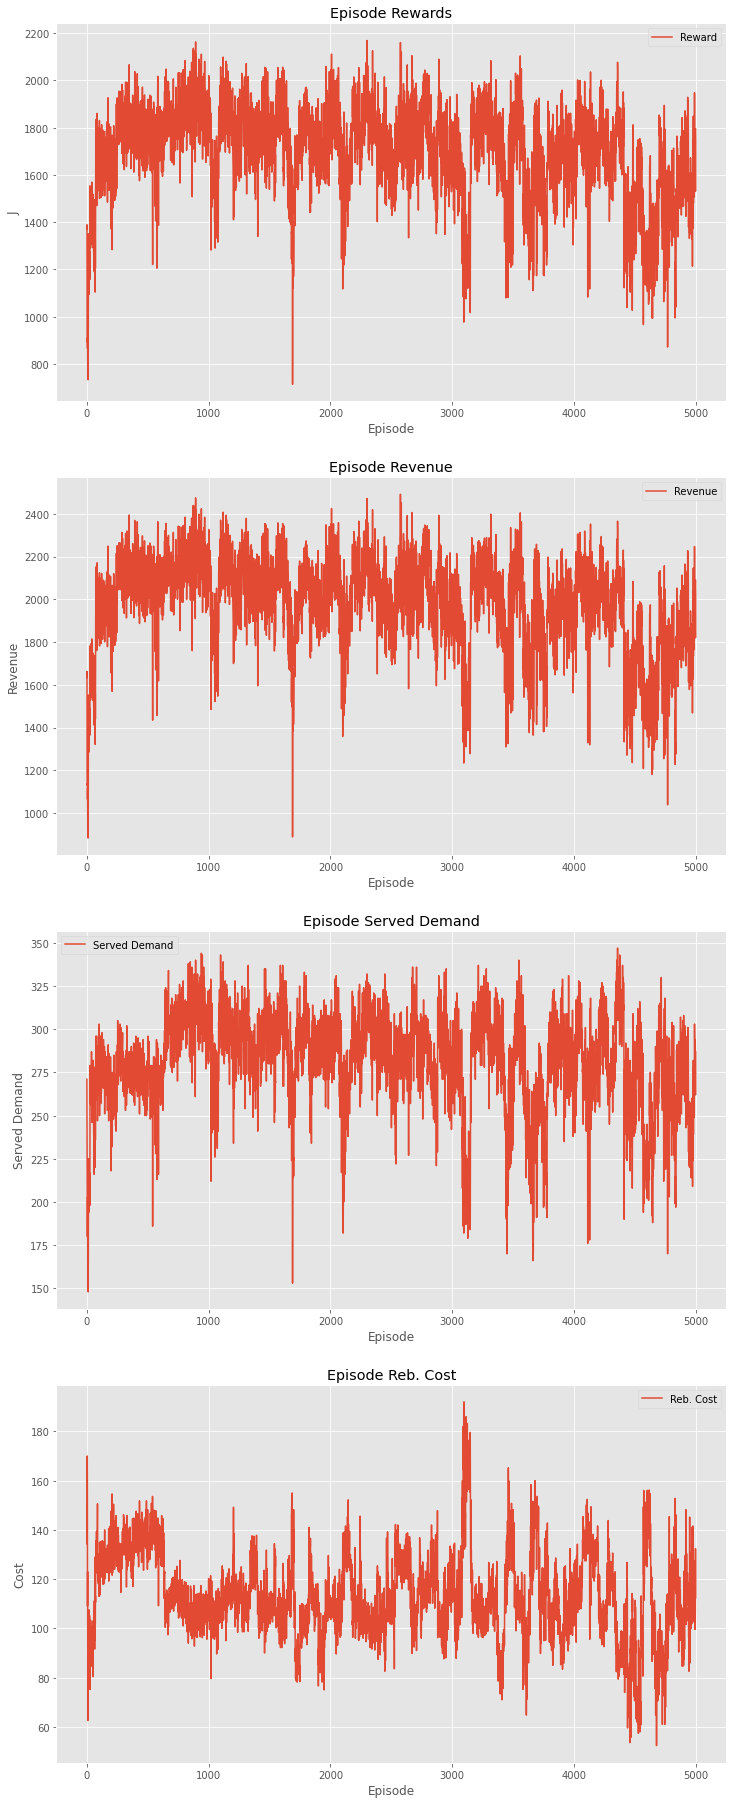

Average Performance: 

Avg Reward: 1698.14
Total Revenue: 1980.43
Total Served Demand: 281.51
Total Rebalancing Cost: 113.46


In [18]:
# Plot results
fig = plt.figure(figsize=(12,32))
fig.add_subplot(411)
plt.plot(training_rewards, label="Reward")
plt.title("Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("J")
plt.legend()

fig.add_subplot(412)
plt.plot(training_revenue, label="Revenue")
plt.title("Episode Revenue")
plt.xlabel("Episode")
plt.ylabel("Revenue")
plt.legend()

fig.add_subplot(413)
plt.plot(training_served_demand, label="Served Demand")
plt.title("Episode Served Demand")
plt.xlabel("Episode")
plt.ylabel("Served Demand")
plt.legend()

fig.add_subplot(414)
plt.plot(training_rebalancing_cost, label="Reb. Cost")
plt.title("Episode Reb. Cost")
plt.xlabel("Episode")
plt.ylabel("Cost")
plt.legend()
plt.show()

print("Average Performance: \n")
print(f'Avg Reward: {np.mean(training_rewards):.2f}')
print(f'Total Revenue: {np.mean(training_revenue):.2f}')
print(f'Total Served Demand: {np.mean(training_served_demand):.2f}')
print(f'Total Rebalancing Cost: {np.mean(training_rebalancing_cost):.2f}')

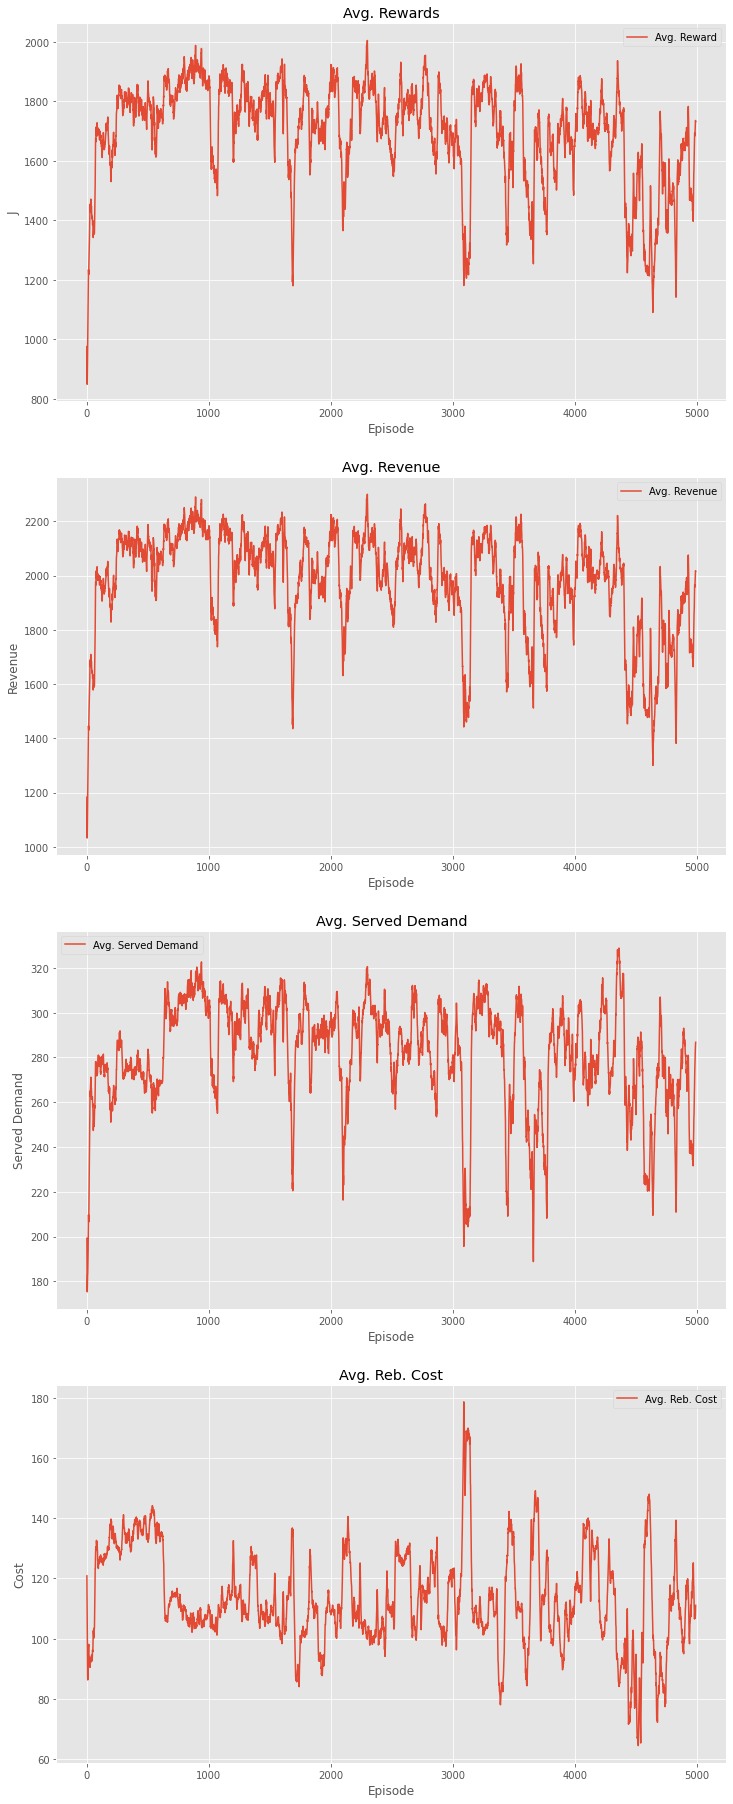

In [19]:
# Plot results with moving average smoothing 
fig = plt.figure(figsize=(12,32))
fig.add_subplot(411)
plt.plot(moving_average(training_rewards, n=10), label="Avg. Reward")
plt.title("Avg. Rewards")
plt.xlabel("Episode")
plt.ylabel("J")
plt.legend()

fig.add_subplot(412)
plt.plot(moving_average(training_revenue, n=10), label="Avg. Revenue")
plt.title("Avg. Revenue")
plt.xlabel("Episode")
plt.ylabel("Revenue")
plt.legend()

fig.add_subplot(413)
plt.plot(moving_average(training_served_demand, n=10), label="Avg. Served Demand")
plt.title("Avg. Served Demand")
plt.xlabel("Episode")
plt.ylabel("Served Demand")
plt.legend()

fig.add_subplot(414)
plt.plot(moving_average(training_rebalancing_cost, n=10), label="Avg. Reb. Cost")
plt.title("Avg. Reb. Cost")
plt.xlabel("Episode")
plt.ylabel("Cost")
plt.legend()
plt.show()

In [30]:
# save learned agent
import pickle
name = "cdqn-s2-base"
with open('local_files/agents/'+ name + '.pkl', 'wb') as f:
    pickle.dump(cdqn, f, pickle.HIGHEST_PROTOCOL)

In [33]:
# load agent
with open('local_files/agents/CDQN/temp/' + name + '.pkl', 'rb') as f:
    temp_agent = pickle.load(f)